In [47]:
import random
import torch
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torch import nn
from collections import deque

In [48]:
env = gym.make('Acrobot-v1') 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [49]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def push(self, state, action, next_state, reward):
        self.memory.append((state, action, next_state, reward))

    def sample(self, batch_size):
        batch_size = min(batch_size, len(self))
        return random.sample(self.memory,batch_size) # Return randomly select "batch_size" samples 

    def __len__(self):
        return len(self.memory)

In [50]:
class DQN(nn.Module):

    def __init__(self, state_space_dim = 6, action_space_dim = 3):
        super().__init__()

        self.linear = nn.Sequential(
                  nn.Linear(state_space_dim,64),
                  nn.ReLU(),
                  nn.Linear(64,64*2),
                  nn.ReLU(),
                  nn.Linear(64*2,action_space_dim)
                )

    def forward(self, x):
        x = x.to(device)
        return self.linear(x)

In [51]:
def choose_action_epsilon_greedy(net, state, epsilon):
    """ This Function either chooses the best action or any other non optimal action depending on value of epsilon"""
    
    # if epsilon > 1 or epsilon < 0:
    #     raise Exception('The epsilon value must be between 0 and 1')
                
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32)
        net_out = net(state)

    best_action = int(net_out.argmax())
    action_space_dim = net_out.shape[-1]

    if random.random() < epsilon:
        non_optimal_actions = [a for a in range(action_space_dim) if a != best_action]
        action = random.choice(non_optimal_actions) 
    else:
        action = best_action # Return best action 
        
    return action, net_out.cpu().numpy()

In [52]:
def choose_action_softmax(net, state, imm_epision):
        
    # If the imm_epision is 0, just select the best action using the eps-greedy policy with epsilon = 0
    if imm_epision == 0:
        return choose_action_epsilon_greedy(net, state, 0)
    
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32)
        net_out = net(state)

    imm_epision = max(imm_epision, 1e-8)
    softmax_out = nn.functional.softmax(net_out/imm_epision, dim=0).cpu().numpy()
                
    all_possible_actions = np.arange(0, softmax_out.shape[-1])
    action = np.random.choice(all_possible_actions,p=softmax_out)
    
    return action, net_out.cpu().numpy()

In [53]:
# Define a exploration profile for exploration vs exploitation
initial_value = 5
num_iterations = 1000
exp_decay = np.exp(-np.log(initial_value) / num_iterations * 6) 
exploration_profile = [initial_value * (exp_decay ** i) for i in range(num_iterations)]

In [54]:
gamma = 0.99  
replay_memory_capacity = 10000   

target_net_update_steps = 10   
batch_size = 256   
min_samples_for_training = 1000

In [55]:

replay_mem = ReplayMemory(replay_memory_capacity) # Initialize the replay memory

policy_net = DQN(6, 3).to(device)

target_net = DQN(6, 3).to(device)
target_net.load_state_dict(policy_net.state_dict()) # Copy the weights

optimizer = torch.optim.Adam(policy_net.parameters(), lr=1e-3) 
loss_fn = nn.SmoothL1Loss()

In [56]:
def update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size):
        
    batch = replay_mem.sample(batch_size)
    batch_size = len(batch)

    states      = torch.tensor([s[0] for s in batch], dtype=torch.float32, device=device)
    actions     = torch.tensor([s[1] for s in batch], dtype=torch.int64, device=device)
    rewards     = torch.tensor([s[3] for s in batch], dtype=torch.float32, device=device)

    non_final_next_states = torch.tensor([s[2] for s in batch if s[2] is not None], dtype=torch.float32, device=device) 
    non_final_mask = torch.tensor([s[2] is not None for s in batch], dtype=torch.bool)

    policy_net.train()
    q_values = policy_net(states)
    state_action_values = q_values.gather(1, actions.unsqueeze(1).cuda())

    with torch.no_grad():
      target_net.eval()
      q_values_target = target_net(non_final_next_states)
    next_state_max_q_values = torch.zeros(batch_size, device=device)
    next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0].detach()

    # Compute the expected Q values
    expected_state_action_values = rewards + (next_state_max_q_values * gamma)
    expected_state_action_values = expected_state_action_values.unsqueeze(1)

    loss = loss_fn(state_action_values, expected_state_action_values)

    optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_norm_(policy_net.parameters(), 2) # For Training Stability 
    optimizer.step()

In [57]:
episode_rewards=[]

for episode_num, tau in enumerate(tqdm(exploration_profile)):

    state = env.reset()[0]
    # print(state)
    return_G = 0
    done = False

    while not done:

      action, q_values = choose_action_softmax(policy_net, state, imm_epision=tau)
      next_state, reward, done, truncated, info = env.step(action)
      return_G += reward
      if done: 
          next_state = None
      
      replay_mem.push(state, action, next_state, reward)

      if len(replay_mem) > min_samples_for_training: # Gather enough samples and train
          update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)

      state = next_state

    # Update Target Network
    if episode_num % target_net_update_steps == 0:
        target_net.load_state_dict(policy_net.state_dict()) # Copy the weights
    
    episode_rewards.append(return_G)
    print("episode:",episode_num, "\trewards:", return_G)

env.close()

  0%|          | 0/1000 [00:00<?, ?it/s]

episode: 0 	rewards: -1044.0
episode: 1 	rewards: -865.0
episode: 2 	rewards: -799.0
episode: 3 	rewards: -1005.0
episode: 4 	rewards: -2428.0
episode: 5 	rewards: -6409.0
episode: 6 	rewards: -1081.0
episode: 7 	rewards: -784.0
episode: 8 	rewards: -3091.0
episode: 9 	rewards: -4368.0
episode: 10 	rewards: -1636.0
episode: 11 	rewards: -638.0
episode: 12 	rewards: -3998.0
episode: 13 	rewards: -3944.0
episode: 14 	rewards: -660.0
episode: 15 	rewards: -729.0
episode: 16 	rewards: -1643.0
episode: 17 	rewards: -3032.0
episode: 18 	rewards: -3783.0
episode: 19 	rewards: -1183.0
episode: 20 	rewards: -3087.0
episode: 21 	rewards: -1401.0
episode: 22 	rewards: -1616.0
episode: 23 	rewards: -2850.0
episode: 24 	rewards: -1548.0
episode: 25 	rewards: -1399.0
episode: 26 	rewards: -2036.0
episode: 27 	rewards: -1404.0
episode: 28 	rewards: -772.0
episode: 29 	rewards: -2528.0
episode: 30 	rewards: -2980.0
episode: 31 	rewards: -542.0
episode: 32 	rewards: -2067.0
episode: 33 	rewards: -2537.

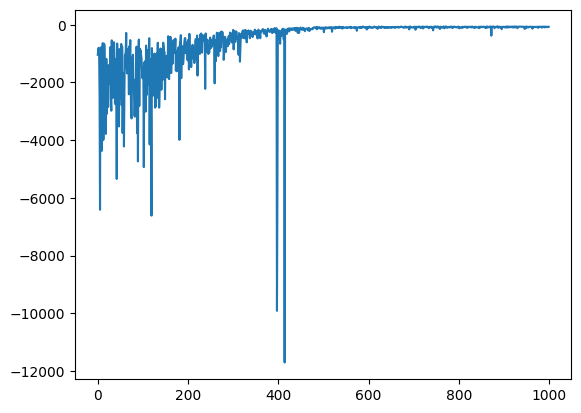

In [58]:
plt.figure()
plt.plot(episode_rewards)
plt.show()